In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="Set2")
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.metrics import ndcg_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Preprcoess Data and DataSplit

In [2]:
def train_test_split(ratings_df, test_ratio=0.2):
    train_list = []
    test_list = []

    for user, group in tqdm(ratings_df.groupby('user_idx')):
        test_size = int(len(group) * test_ratio)
        test_sample = group.sample(n=test_size, random_state=42)
        train_sample = group.drop(test_sample.index)

        train_list.append(train_sample)
        test_list.append(test_sample)

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df


def preprocess_data(data_path):
    print("Preprocessing data...")
    r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
    ratings = pd.read_csv(data_path, sep='::', names=r_cols, engine='python', encoding='latin-1')

    user_ids = ratings['user_id'].unique().tolist()
    user2idx = {user_id: i for i, user_id in enumerate(user_ids)}
    ratings['user_idx'] = ratings['user_id'].apply(lambda x: user2idx[x])

    movie_ids = ratings['movie_id'].unique().tolist()
    movie2idx = {movie_id: i for i, movie_id in enumerate(movie_ids)}
    ratings['movie_idx'] = ratings['movie_id'].apply(lambda x: movie2idx[x])

    train_df, test_df = train_test_split(ratings, 0.2)
    
    num_users = len(user2idx)
    num_items = len(movie2idx)

    print(f"Number of unique users: {num_users}")
    print(f"Number of unique items: {num_items}")
    print(f"Total ratings: {len(ratings)}")

    
    return ratings, num_users, num_items, user2idx, movie2idx, train_df, test_df

ratings_df, num_users, num_items, user2idx, movie2idx, train_df, test_df = preprocess_data("data/ml-1M/ratings.dat")
display(ratings_df)

Preprocessing data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:02<00:00, 2807.30it/s]


Number of unique users: 6040
Number of unique items: 3706
Total ratings: 1000209


,user_id,movie_id,rating,timestamp,user_idx,movie_idx
0,1,1193,5,978300760,0,0
1,1,661,3,978302109,0,1
2,1,914,3,978301968,0,2
3,1,3408,4,978300275,0,3
4,1,2355,5,978824291,0,4
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,6039,772
1000205,6040,1094,5,956704887,6039,1106
1000206,6040,562,5,956704746,6039,365
1000207,6040,1096,4,956715648,6039,152


## EDA

### 1) Are there any duplicate ratings?

In [3]:
ratings_df[ratings_df.duplicated(subset = ['user_idx', 'movie_idx'])]

,user_id,movie_id,rating,timestamp,user_idx,movie_idx


There are **no duplicate entries** found. For example, there is no case where the same user has logged 2 different rating entries for the same movie

### 2) What is the distribution of number of ratings logged per user

In [4]:
user_counts = ratings_df['user_idx'].value_counts().reset_index()
user_counts.head(3)

,user_idx,count
0,4168,2314
1,1679,1850
2,4276,1743


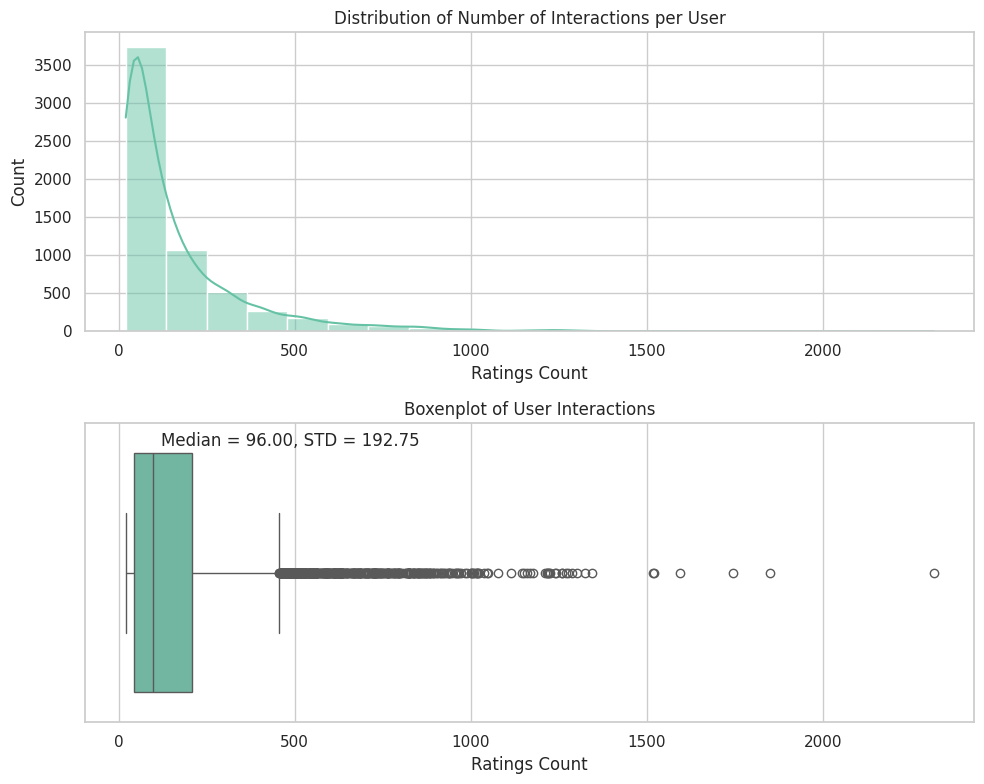

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(data=user_counts['count'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Number of Interactions per User')
ax[0].set_xlabel('Ratings Count')
ax[0].set_ylabel('Count')

# Plot the boxenplot on the second subplot (ax[1])
sns.boxplot(x=user_counts['count'], ax=ax[1])
median_val = user_counts['count'].median()
std_val = user_counts['count'].std()
# ax[1].axvline(median_val, color='black', linestyle='--')
ax[1].text(x=median_val + 25, y=-0.425, s=f"Median = {median_val:.2f}, STD = {std_val:.2f}")
ax[1].set_title('Boxenplot of User Interactions')
ax[1].set_xlabel('Ratings Count')
ax[1].set_ylabel('')

plt.tight_layout()

# Display the plot
plt.show()


- A long right tail in the kdeplot
- A standard deviation (~193) being double of Median (96) for a value (count) which is always positive resulting in outliers beyond the right whisker

There are very few users who have a high number of interactions (e.g., over 500 interactions).

### 2) What is the distribution of number of ratings logged per movie

In [6]:
movie_counts = ratings_df['movie_idx'].value_counts().reset_index()
movie_counts.head(3)

,movie_idx,count
0,104,3428
1,44,2991
2,124,2990


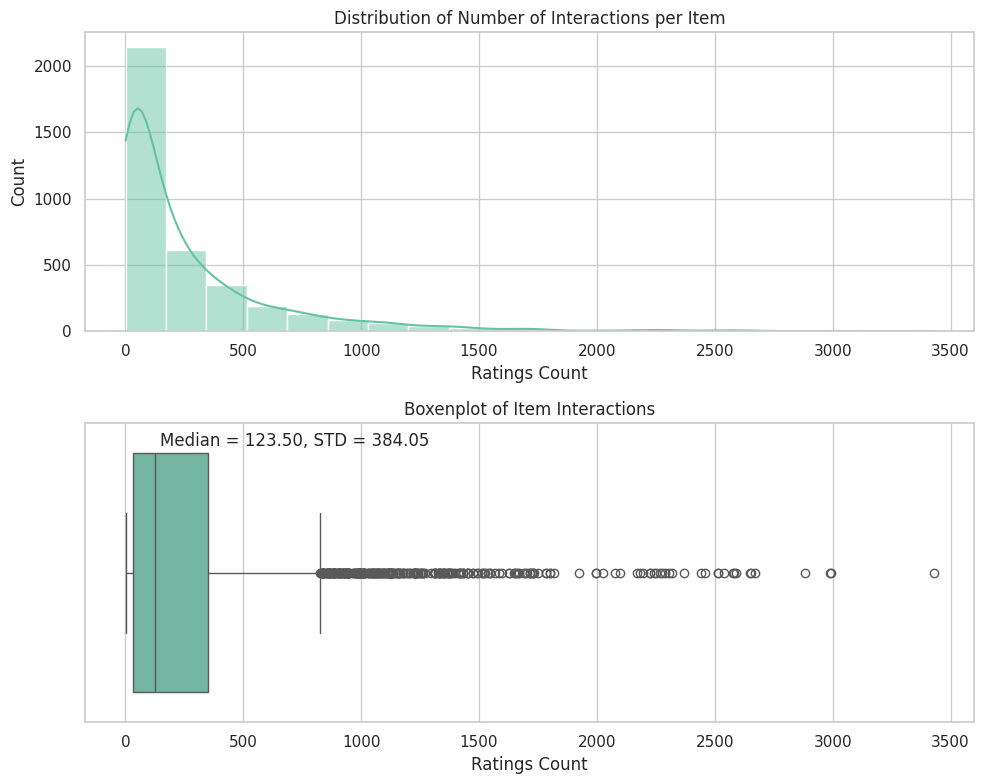

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(data=movie_counts['count'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Number of Interactions per Item')
ax[0].set_xlabel('Ratings Count')
ax[0].set_ylabel('Count')

# Plot the boxenplot on the second subplot (ax[1])
sns.boxplot(x=movie_counts['count'], ax=ax[1])
median_val = movie_counts['count'].median()
std_val = movie_counts['count'].std()
# ax[1].axvline(median_val, color='black', linestyle='--')
ax[1].text(x=median_val + 25, y=-0.425, s=f"Median = {median_val:.2f}, STD = {std_val:.2f}")
ax[1].set_title('Boxenplot of Item Interactions')
ax[1].set_xlabel('Ratings Count')
ax[1].set_ylabel('')

plt.tight_layout()

# Display the plot
plt.show()


- Number of interactions per item has a longer right tail suggesting that some movies were more frequently watched (hence rated) by more users

- Hypothesis: The number of ratings recieved for each movie could be suggestive of the popularity of the movie. Lets test this in the following section

### 3. Average Rating per movie Distribution

In [8]:
avg_movie_rating = ratings_df.groupby('movie_idx')['rating'].mean().reset_index()
avg_movie_rating_count = pd.merge(avg_movie_rating, movie_counts, on='movie_idx')

rating_bins = np.arange(1,5.5,0.5)
rating_bins_string = [f'{rating_bins[i]:.1f}-{rating_bins[i+1]:.1f}' for i in range(len(rating_bins) -1)]

def binify_rating(x):
    for i in range(len(rating_bins)-1):
        if x >= rating_bins[i] and x <= rating_bins[i+1]:
            return rating_bins_string[i]

count_bins = np.arange(0,movie_counts['count'].max()+200,200)
count_bins_string = [f'{count_bins[i]}-{count_bins[i+1]}' for i in range(len(count_bins) -1)]

def binify_counts(x):
    for i in range(len(count_bins)-1):
        if x >= count_bins[i] and x <= count_bins[i+1]:
            return count_bins_string[i]


avg_movie_rating_count['rating_bin'] = avg_movie_rating_count['rating'].apply(binify_rating)
avg_movie_rating_count['counts_bin'] = avg_movie_rating_count['count'].apply(binify_counts)

avg_movie_rating_count

,movie_idx,rating,count,rating_bin,counts_bin
0,0,4.390725,1725,4.0-4.5,1600-1800
1,1,3.464762,525,3.0-3.5,400-600
2,2,4.154088,636,4.0-4.5,600-800
3,3,3.863878,1315,3.5-4.0,1200-1400
4,4,3.854375,1703,3.5-4.0,1600-1800
...,...,...,...,...,...
3701,3701,4.000000,2,3.5-4.0,0-200
3702,3702,3.000000,1,2.5-3.0,0-200
3703,3703,1.000000,1,1.0-1.5,0-200
3704,3704,5.000000,1,4.5-5.0,0-200


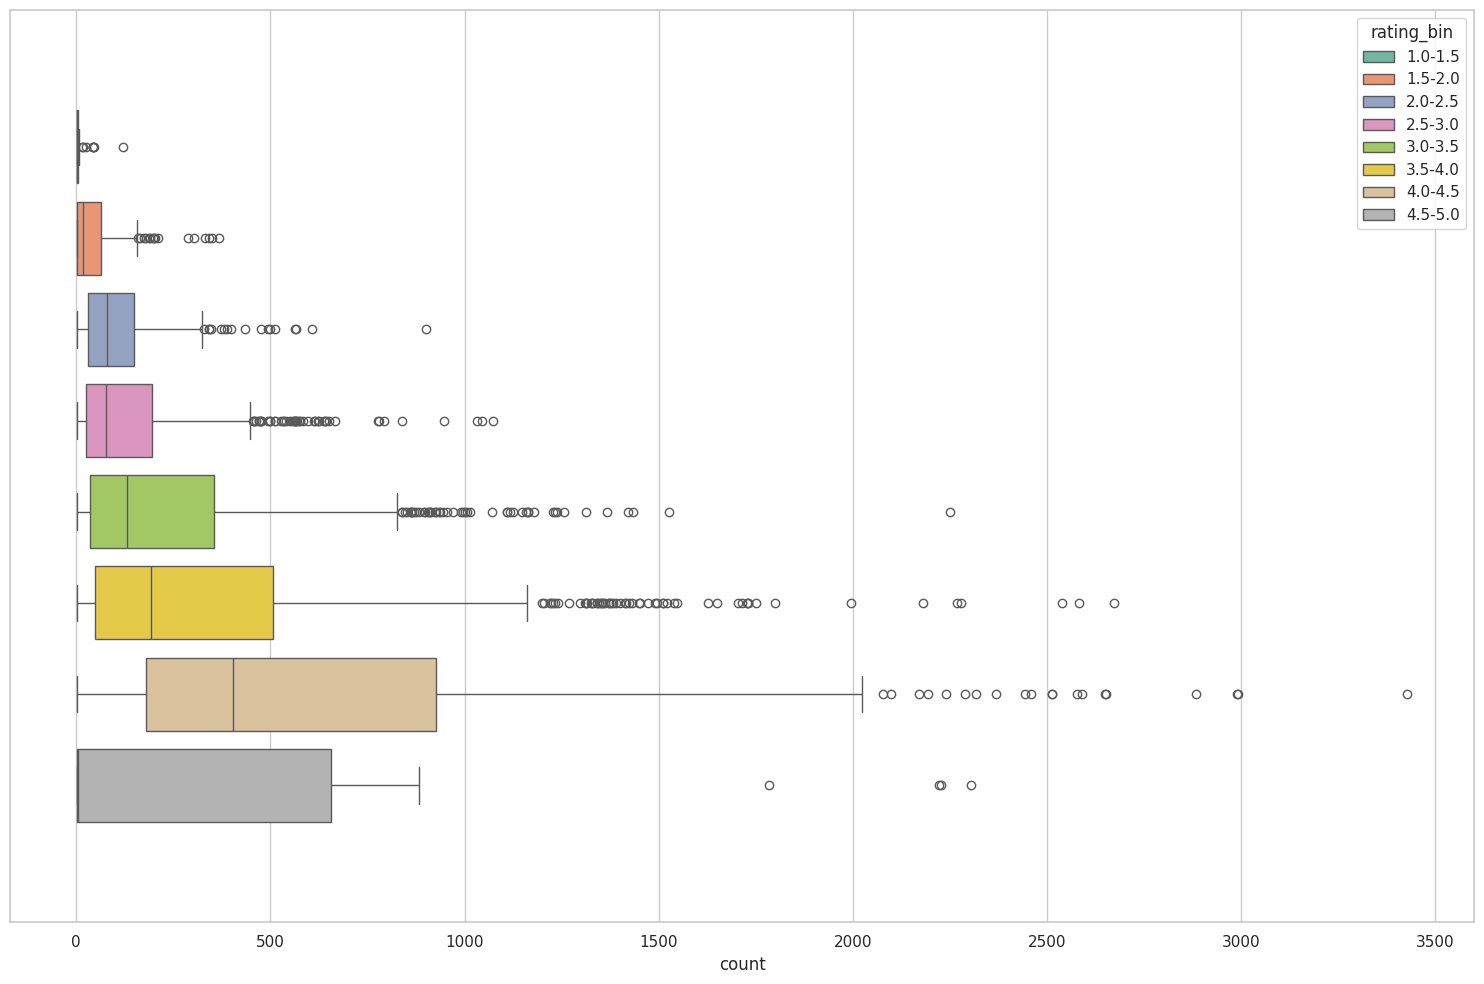

In [9]:
plt.figure(figsize=(15,10))
sns.boxplot(data=avg_movie_rating_count, x='count', hue='rating_bin', fill=True, hue_order=rating_bins_string, gap = 0.2)
plt.tight_layout()
plt.show()

#### There definitely seems a correlation between the number of ratings a movie recieved with the average movie rating. Due to this, we will be using the average rating of a movie as proxy for popularity.

## Modelling

### DataLoader

In [10]:
### Configs

alpha = 40      # used in the paper
batch_size = 8192
d_model = 128    
device = "cuda:0"
lr = 3e-4       # andrej karpathy magic number :)

In [11]:
class ImplicitALSDataSet(Dataset):
    def __init__(self, users, items, ratings, alpha):
        self.users = np.array(users)
        self.items = np.array(items)
        self.ratings = np.array(ratings)
        self.confidences = 1 + alpha * self.ratings
        self.positives = (self.ratings > 0).astype(float)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {'user' : self.users[idx], 'item' : self.items[idx], 'confidence' : self.confidences[idx], 'preference' : self.positives[idx]}

train_users, train_items, train_ratings = train_df['user_idx'].to_list(), train_df['movie_idx'].to_list(), train_df['rating'].to_list()
test_users, test_items, test_ratings = test_df['user_idx'].to_list(), test_df['movie_idx'].to_list(), test_df['rating'].to_list()

train_ds = ImplicitALSDataSet(train_users, train_items, train_ratings, alpha=alpha)
test_ds = ImplicitALSDataSet(test_users, test_items, test_ratings, alpha=alpha)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=32)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=32)

### Approach 1: Implicit ALS with confidence

We consider ratings to be implicit in nature. Following this for resources and implementing the algorith mentioned [here](https://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/#Implicit-ALS). 

**I have implemeted this with deep learning so as to speed up the training process.**

#### Model

In [12]:
class ImplicitMF(nn.Module):
    def __init__(self, num_users, num_items, d_model):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.d_model = d_model
        self.user_embeddings = nn.Embedding(self.num_users, d_model)
        self.item_embeddings = nn.Embedding(self.num_items, d_model)

    def forward(self, user, item):
        u = self.user_embeddings(user)
        v = self.item_embeddings(item)
        return (u * v).sum(dim=1)

#### Train Loop

In [13]:
def loop(model, optimiser, dataloader, reg_lambda, device, epoch, verbose=True, train=True):
    model = model.to(device)    
    total_loss = []
    iterator = tqdm(dataloader) if verbose else dataloader
    for batch in iterator:
        iterator.set_description(f"Epoch {epoch}  ||  Total Loss : {np.array(total_loss).mean():.4f}")
        user = batch['user'].to(device)
        item = batch['item'].to(device)
        confidence = batch['confidence'].to(device)
        preference = batch['preference'].to(device)

        if train:
            pred = model(user, item)
            loss = (confidence * ((preference - pred) ** 2)).mean()
            reg = reg_lambda * (model.user_embeddings(user.unique()).norm(2).pow(2) + model.item_embeddings(item.unique()).norm(2).pow(2))
            loss += reg
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            total_loss.append(loss.item())
        else:
            with torch.no_grad():
                pred = model(user, item)
                loss = (confidence * ((preference - pred) ** 2)).mean()
                reg = reg_lambda * (model.user_embeddings(user.unique()).norm(2).pow(2) + model.item_embeddings(item.unique()).norm(2).pow(2))
                loss += reg
                total_loss.append(loss.item())
    return np.array(total_loss).mean()


def run(model, optimiser, train_dataloader, test_dataloader, reg_lambda, device, ckpt_path, epochs=20, verbose=True, patience=5):
    best_test_loss = 1e6
    train_losses = []
    test_losses = []

    counter = patience
    for epoch in range(epochs):
        if counter == 0:
            print("ENDING TRAINING LOOP DUE TO PATIENCE!!")
            break
        train_loss = loop(model, optimiser, train_dataloader, reg_lambda, device, epoch, verbose=True, train=True)
        test_loss = loop(model, optimiser, test_dataloader, reg_lambda, device, epoch, verbose=True, train=False)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if test_loss < best_test_loss:
            counter = patience
            torch.save({
                        'epoch' : epoch,
                        'val_loss' : test_loss,
                        'state_dict' : model.state_dict()
                    }, ckpt_path)
            best_test_loss = test_loss
            print("Saving CKPT")
        else:
            counter -= 1
        print("\n")
    return train_losses, test_losses

In [14]:
model = ImplicitMF(num_users, num_items, d_model)
optimiser = optim.Adam(model.parameters(), lr=lr)
ckpt_path = "models/implicitALSDL.pt"
train_losses, test_losses = run(model, optimiser, train_loader, test_loader, reg_lambda=0.1, device=device, ckpt_path=ckpt_path, epochs=200, verbose=True)

  0%|                                                                                                                                                                | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_3379851/395189826.py:6: RuntimeWarning: Mean of empty slice.
  iterator.set_description(f"Epoch {epoch}  ||  Total Loss : {np.array(total_loss).mean():.4f}")
/opt2/shreyas/miniconda3/envs/cf/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 0  ||  Total Loss : 88664.9092: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 81.86it/s]
Epoch 0  ||  Total Loss : 87466.1244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.79it/s]


Saving CKPT




Epoch 1  ||  Total Loss : 86532.5139: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.27it/s]
Epoch 1  ||  Total Loss : 85698.9192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.23it/s]


Saving CKPT




Epoch 2  ||  Total Loss : 84545.0952: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.52it/s]
Epoch 2  ||  Total Loss : 83522.9495: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.30it/s]


Saving CKPT




Epoch 3  ||  Total Loss : 82564.3110: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 109.41it/s]
Epoch 3  ||  Total Loss : 81755.6831: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.62it/s]


Saving CKPT




Epoch 4  ||  Total Loss : 80555.1525: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.96it/s]
Epoch 4  ||  Total Loss : 79891.6288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.89it/s]


Saving CKPT




Epoch 5  ||  Total Loss : 78728.5401: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.82it/s]
Epoch 5  ||  Total Loss : 78137.1299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.86it/s]


Saving CKPT




Epoch 6  ||  Total Loss : 76840.1776: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.32it/s]
Epoch 6  ||  Total Loss : 76383.9378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.26it/s]


Saving CKPT




Epoch 7  ||  Total Loss : 75077.1567: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 109.05it/s]
Epoch 7  ||  Total Loss : 74715.4761: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.56it/s]


Saving CKPT




Epoch 8  ||  Total Loss : 73276.2091: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.51it/s]
Epoch 8  ||  Total Loss : 72931.1046: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.73it/s]


Saving CKPT




Epoch 9  ||  Total Loss : 71517.9407: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 111.34it/s]
Epoch 9  ||  Total Loss : 71198.4483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.81it/s]


Saving CKPT




Epoch 10  ||  Total Loss : 69847.5552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.69it/s]
Epoch 10  ||  Total Loss : 69652.3195: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.56it/s]


Saving CKPT




Epoch 11  ||  Total Loss : 68172.8188: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 111.38it/s]
Epoch 11  ||  Total Loss : 67998.8154: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.19it/s]


Saving CKPT




Epoch 12  ||  Total Loss : 66583.6925: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.35it/s]
Epoch 12  ||  Total Loss : 66440.5636: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.35it/s]


Saving CKPT




Epoch 13  ||  Total Loss : 64967.6923: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.42it/s]
Epoch 13  ||  Total Loss : 64853.4122: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.36it/s]


Saving CKPT




Epoch 14  ||  Total Loss : 63385.4402: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.65it/s]
Epoch 14  ||  Total Loss : 63424.1830: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.55it/s]


Saving CKPT




Epoch 15  ||  Total Loss : 61848.0039: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 110.27it/s]
Epoch 15  ||  Total Loss : 61844.7985: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.52it/s]


Saving CKPT




Epoch 16  ||  Total Loss : 60340.6466: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.14it/s]
Epoch 16  ||  Total Loss : 60472.6363: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.94it/s]


Saving CKPT




Epoch 17  ||  Total Loss : 58839.2797: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.00it/s]
Epoch 17  ||  Total Loss : 58901.5404: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.08it/s]


Saving CKPT




Epoch 18  ||  Total Loss : 57417.0308: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.00it/s]
Epoch 18  ||  Total Loss : 57534.6953: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.70it/s]


Saving CKPT




Epoch 19  ||  Total Loss : 55987.8891: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.68it/s]
Epoch 19  ||  Total Loss : 55993.0700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.33it/s]


Saving CKPT




Epoch 20  ||  Total Loss : 54571.6337: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.21it/s]
Epoch 20  ||  Total Loss : 54742.6738: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.04it/s]


Saving CKPT




Epoch 21  ||  Total Loss : 53232.6489: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.29it/s]
Epoch 21  ||  Total Loss : 53332.7465: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.82it/s]


Saving CKPT




Epoch 22  ||  Total Loss : 51861.9943: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 109.45it/s]
Epoch 22  ||  Total Loss : 52022.4331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.87it/s]


Saving CKPT




Epoch 23  ||  Total Loss : 50543.6149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.90it/s]
Epoch 23  ||  Total Loss : 50716.7641: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.64it/s]


Saving CKPT




Epoch 24  ||  Total Loss : 49217.5083: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.12it/s]
Epoch 24  ||  Total Loss : 49378.7410: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.15it/s]


Saving CKPT




Epoch 25  ||  Total Loss : 47936.6723: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.70it/s]
Epoch 25  ||  Total Loss : 48098.4207: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.43it/s]


Saving CKPT




Epoch 26  ||  Total Loss : 46714.0832: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 110.37it/s]
Epoch 26  ||  Total Loss : 46891.4248: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.00it/s]


Saving CKPT




Epoch 27  ||  Total Loss : 45432.8221: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 110.80it/s]
Epoch 27  ||  Total Loss : 45631.4193: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.03it/s]


Saving CKPT




Epoch 28  ||  Total Loss : 44241.9374: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.31it/s]
Epoch 28  ||  Total Loss : 44381.1527: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.33it/s]


Saving CKPT




Epoch 29  ||  Total Loss : 43028.2899: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.33it/s]
Epoch 29  ||  Total Loss : 43220.6890: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.59it/s]


Saving CKPT




Epoch 30  ||  Total Loss : 41871.2997: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.62it/s]
Epoch 30  ||  Total Loss : 41987.3487: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.61it/s]


Saving CKPT




Epoch 31  ||  Total Loss : 40699.6288: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.94it/s]
Epoch 31  ||  Total Loss : 40831.0672: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 30.75it/s]


Saving CKPT




Epoch 32  ||  Total Loss : 39572.8190: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 63.25it/s]
Epoch 32  ||  Total Loss : 39745.6548: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.86it/s]


Saving CKPT




Epoch 33  ||  Total Loss : 38443.6453: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.69it/s]
Epoch 33  ||  Total Loss : 38521.1452: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.64it/s]


Saving CKPT




Epoch 34  ||  Total Loss : 37342.6587: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.29it/s]
Epoch 34  ||  Total Loss : 37433.3778: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.01it/s]


Saving CKPT




Epoch 35  ||  Total Loss : 36289.5248: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.22it/s]
Epoch 35  ||  Total Loss : 36384.0626: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.41it/s]


Saving CKPT




Epoch 36  ||  Total Loss : 35228.1848: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.88it/s]
Epoch 36  ||  Total Loss : 35331.7556: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.86it/s]


Saving CKPT




Epoch 37  ||  Total Loss : 34171.2551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.29it/s]
Epoch 37  ||  Total Loss : 34282.2053: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.08it/s]


Saving CKPT




Epoch 38  ||  Total Loss : 33145.4579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.80it/s]
Epoch 38  ||  Total Loss : 33201.0643: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.83it/s]


Saving CKPT




Epoch 39  ||  Total Loss : 32168.4120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.92it/s]
Epoch 39  ||  Total Loss : 32216.1669: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.38it/s]


Saving CKPT




Epoch 40  ||  Total Loss : 31186.7265: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 109.87it/s]
Epoch 40  ||  Total Loss : 31200.5854: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.21it/s]


Saving CKPT




Epoch 41  ||  Total Loss : 30219.9019: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.76it/s]
Epoch 41  ||  Total Loss : 30171.9681: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.53it/s]


Saving CKPT




Epoch 42  ||  Total Loss : 29260.7979: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.28it/s]
Epoch 42  ||  Total Loss : 29254.7448: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.17it/s]


Saving CKPT




Epoch 43  ||  Total Loss : 28344.4459: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.63it/s]
Epoch 43  ||  Total Loss : 28339.3182: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.19it/s]


Saving CKPT




Epoch 44  ||  Total Loss : 27435.3331: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.58it/s]
Epoch 44  ||  Total Loss : 27406.1375: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.42it/s]


Saving CKPT




Epoch 45  ||  Total Loss : 26524.0924: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.83it/s]
Epoch 45  ||  Total Loss : 26524.4426: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.87it/s]


Saving CKPT




Epoch 46  ||  Total Loss : 25660.5584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.85it/s]
Epoch 46  ||  Total Loss : 25615.6593: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.34it/s]


Saving CKPT




Epoch 47  ||  Total Loss : 24806.3457: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.18it/s]
Epoch 47  ||  Total Loss : 24740.6813: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.13it/s]


Saving CKPT




Epoch 48  ||  Total Loss : 23953.1800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.17it/s]
Epoch 48  ||  Total Loss : 23912.3656: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.76it/s]


Saving CKPT




Epoch 49  ||  Total Loss : 23122.8298: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.25it/s]
Epoch 49  ||  Total Loss : 23057.9872: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.50it/s]


Saving CKPT




Epoch 50  ||  Total Loss : 22329.0541: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.13it/s]
Epoch 50  ||  Total Loss : 22224.0158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.22it/s]


Saving CKPT




Epoch 51  ||  Total Loss : 21542.2214: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 101.71it/s]
Epoch 51  ||  Total Loss : 21432.1340: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.15it/s]


Saving CKPT




Epoch 52  ||  Total Loss : 20773.7770: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.22it/s]
Epoch 52  ||  Total Loss : 20687.0870: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.58it/s]


Saving CKPT




Epoch 53  ||  Total Loss : 20000.8061: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.67it/s]
Epoch 53  ||  Total Loss : 19896.8468: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.47it/s]


Saving CKPT




Epoch 54  ||  Total Loss : 19284.7807: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.66it/s]
Epoch 54  ||  Total Loss : 19167.3769: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.68it/s]


Saving CKPT




Epoch 55  ||  Total Loss : 18567.2562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 101.62it/s]
Epoch 55  ||  Total Loss : 18458.2820: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.94it/s]


Saving CKPT




Epoch 56  ||  Total Loss : 17881.9930: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.38it/s]
Epoch 56  ||  Total Loss : 17735.3739: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 41.29it/s]


Saving CKPT




Epoch 57  ||  Total Loss : 17190.8102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 101.66it/s]
Epoch 57  ||  Total Loss : 17036.6714: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 58  ||  Total Loss : 16522.3333: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.20it/s]
Epoch 58  ||  Total Loss : 16400.1853: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Saving CKPT




Epoch 59  ||  Total Loss : 15878.9767: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.19it/s]
Epoch 59  ||  Total Loss : 15739.2317: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.17it/s]


Saving CKPT




Epoch 60  ||  Total Loss : 15247.2835: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.74it/s]
Epoch 60  ||  Total Loss : 15084.1206: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.34it/s]


Saving CKPT




Epoch 61  ||  Total Loss : 14646.2624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.90it/s]
Epoch 61  ||  Total Loss : 14475.6429: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.45it/s]


Saving CKPT




Epoch 62  ||  Total Loss : 14049.2207: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.21it/s]
Epoch 62  ||  Total Loss : 13856.9239: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.62it/s]


Saving CKPT




Epoch 63  ||  Total Loss : 13462.4614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.36it/s]
Epoch 63  ||  Total Loss : 13292.0887: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.50it/s]


Saving CKPT




Epoch 64  ||  Total Loss : 12904.2560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.63it/s]
Epoch 64  ||  Total Loss : 12771.2927: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.39it/s]


Saving CKPT




Epoch 65  ||  Total Loss : 12370.0129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.30it/s]
Epoch 65  ||  Total Loss : 12195.9145: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.82it/s]


Saving CKPT




Epoch 66  ||  Total Loss : 11852.9974: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.73it/s]
Epoch 66  ||  Total Loss : 11684.9878: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.08it/s]


Saving CKPT




Epoch 67  ||  Total Loss : 11332.9790: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.30it/s]
Epoch 67  ||  Total Loss : 11167.2149: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.80it/s]


Saving CKPT




Epoch 68  ||  Total Loss : 10860.3424: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.73it/s]
Epoch 68  ||  Total Loss : 10669.4649: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.97it/s]


Saving CKPT




Epoch 69  ||  Total Loss : 10378.4017: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.38it/s]
Epoch 69  ||  Total Loss : 10201.0512: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.12it/s]


Saving CKPT




Epoch 70  ||  Total Loss : 9907.9527: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.88it/s]
Epoch 70  ||  Total Loss : 9767.4478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.30it/s]


Saving CKPT




Epoch 71  ||  Total Loss : 9471.2234: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.12it/s]
Epoch 71  ||  Total Loss : 9311.2146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.80it/s]


Saving CKPT




Epoch 72  ||  Total Loss : 9049.3574: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.73it/s]
Epoch 72  ||  Total Loss : 8873.3665: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.76it/s]


Saving CKPT




Epoch 73  ||  Total Loss : 8639.9138: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.41it/s]
Epoch 73  ||  Total Loss : 8471.8285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.43it/s]


Saving CKPT




Epoch 74  ||  Total Loss : 8234.4601: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.18it/s]
Epoch 74  ||  Total Loss : 8069.1504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.57it/s]


Saving CKPT




Epoch 75  ||  Total Loss : 7864.6446: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.55it/s]
Epoch 75  ||  Total Loss : 7707.6729: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.32it/s]


Saving CKPT




Epoch 76  ||  Total Loss : 7498.6883: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.19it/s]
Epoch 76  ||  Total Loss : 7340.4562: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.37it/s]


Saving CKPT




Epoch 77  ||  Total Loss : 7146.2676: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.00it/s]
Epoch 77  ||  Total Loss : 7009.2185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.88it/s]


Saving CKPT




Epoch 78  ||  Total Loss : 6820.1899: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.58it/s]
Epoch 78  ||  Total Loss : 6674.3284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.51it/s]


Saving CKPT




Epoch 79  ||  Total Loss : 6491.3948: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.50it/s]
Epoch 79  ||  Total Loss : 6342.1343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.29it/s]


Saving CKPT




Epoch 80  ||  Total Loss : 6185.4927: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.90it/s]
Epoch 80  ||  Total Loss : 6046.8473: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.76it/s]


Saving CKPT




Epoch 81  ||  Total Loss : 5892.5013: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.44it/s]
Epoch 81  ||  Total Loss : 5761.0025: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.56it/s]


Saving CKPT




Epoch 82  ||  Total Loss : 5608.9630: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.44it/s]
Epoch 82  ||  Total Loss : 5486.8302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.69it/s]


Saving CKPT




Epoch 83  ||  Total Loss : 5337.7915: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.94it/s]
Epoch 83  ||  Total Loss : 5220.4383: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.25it/s]


Saving CKPT




Epoch 84  ||  Total Loss : 5082.4068: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.18it/s]
Epoch 84  ||  Total Loss : 4963.0414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.78it/s]


Saving CKPT




Epoch 85  ||  Total Loss : 4840.1465: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.64it/s]
Epoch 85  ||  Total Loss : 4732.0314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.32it/s]


Saving CKPT




Epoch 86  ||  Total Loss : 4606.1653: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.43it/s]
Epoch 86  ||  Total Loss : 4498.3011: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.41it/s]


Saving CKPT




Epoch 87  ||  Total Loss : 4381.3722: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.89it/s]
Epoch 87  ||  Total Loss : 4289.5456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.12it/s]


Saving CKPT




Epoch 88  ||  Total Loss : 4166.2298: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.65it/s]
Epoch 88  ||  Total Loss : 4073.4876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.21it/s]


Saving CKPT




Epoch 89  ||  Total Loss : 3973.8158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.55it/s]
Epoch 89  ||  Total Loss : 3872.3733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.33it/s]


Saving CKPT




Epoch 90  ||  Total Loss : 3783.0136: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.43it/s]
Epoch 90  ||  Total Loss : 3696.9350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.41it/s]


Saving CKPT




Epoch 91  ||  Total Loss : 3598.3751: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.17it/s]
Epoch 91  ||  Total Loss : 3514.5122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.24it/s]


Saving CKPT




Epoch 92  ||  Total Loss : 3426.4126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.30it/s]
Epoch 92  ||  Total Loss : 3357.0169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.54it/s]


Saving CKPT




Epoch 93  ||  Total Loss : 3263.0799: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.33it/s]
Epoch 93  ||  Total Loss : 3185.4591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.54it/s]


Saving CKPT




Epoch 94  ||  Total Loss : 3104.8453: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.70it/s]
Epoch 94  ||  Total Loss : 3035.4936: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.67it/s]


Saving CKPT




Epoch 95  ||  Total Loss : 2959.1618: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.00it/s]
Epoch 95  ||  Total Loss : 2896.7904: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.49it/s]


Saving CKPT




Epoch 96  ||  Total Loss : 2819.7487: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.79it/s]
Epoch 96  ||  Total Loss : 2753.2453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.54it/s]


Saving CKPT




Epoch 97  ||  Total Loss : 2683.6579: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.13it/s]
Epoch 97  ||  Total Loss : 2624.9051: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.97it/s]


Saving CKPT




Epoch 98  ||  Total Loss : 2559.4092: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.86it/s]
Epoch 98  ||  Total Loss : 2506.8442: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.12it/s]


Saving CKPT




Epoch 99  ||  Total Loss : 2441.4922: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.95it/s]
Epoch 99  ||  Total Loss : 2391.2787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.11it/s]


Saving CKPT




Epoch 100  ||  Total Loss : 2325.6056: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.85it/s]
Epoch 100  ||  Total Loss : 2277.1716: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.98it/s]


Saving CKPT




Epoch 101  ||  Total Loss : 2220.4293: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.25it/s]
Epoch 101  ||  Total Loss : 2174.6751: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.17it/s]


Saving CKPT




Epoch 102  ||  Total Loss : 2117.8907: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.81it/s]
Epoch 102  ||  Total Loss : 2077.0680: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.22it/s]


Saving CKPT




Epoch 103  ||  Total Loss : 2023.8758: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.48it/s]
Epoch 103  ||  Total Loss : 1982.0536: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Saving CKPT




Epoch 104  ||  Total Loss : 1927.7968: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.20it/s]
Epoch 104  ||  Total Loss : 1896.1705: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.82it/s]


Saving CKPT




Epoch 105  ||  Total Loss : 1845.3023: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.84it/s]
Epoch 105  ||  Total Loss : 1809.5543: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.64it/s]


Saving CKPT




Epoch 106  ||  Total Loss : 1763.7614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.22it/s]
Epoch 106  ||  Total Loss : 1728.5257: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.06it/s]


Saving CKPT




Epoch 107  ||  Total Loss : 1686.5333: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.44it/s]
Epoch 107  ||  Total Loss : 1652.7670: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.76it/s]


Saving CKPT




Epoch 108  ||  Total Loss : 1612.6825: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.72it/s]
Epoch 108  ||  Total Loss : 1584.0054: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.28it/s]


Saving CKPT




Epoch 109  ||  Total Loss : 1541.8911: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.94it/s]
Epoch 109  ||  Total Loss : 1516.7817: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.74it/s]


Saving CKPT




Epoch 110  ||  Total Loss : 1476.6375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.16it/s]
Epoch 110  ||  Total Loss : 1450.7930: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.73it/s]


Saving CKPT




Epoch 111  ||  Total Loss : 1412.7996: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.75it/s]
Epoch 111  ||  Total Loss : 1396.3199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.86it/s]


Saving CKPT




Epoch 112  ||  Total Loss : 1355.3554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.60it/s]
Epoch 112  ||  Total Loss : 1337.4712: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.81it/s]


Saving CKPT




Epoch 113  ||  Total Loss : 1299.8396: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.00it/s]
Epoch 113  ||  Total Loss : 1284.4050: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.17it/s]


Saving CKPT




Epoch 114  ||  Total Loss : 1244.8502: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.27it/s]
Epoch 114  ||  Total Loss : 1228.0286: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.72it/s]


Saving CKPT




Epoch 115  ||  Total Loss : 1195.7753: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.52it/s]
Epoch 115  ||  Total Loss : 1180.5152: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.46it/s]


Saving CKPT




Epoch 116  ||  Total Loss : 1147.4930: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.37it/s]
Epoch 116  ||  Total Loss : 1136.7335: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.77it/s]


Saving CKPT




Epoch 117  ||  Total Loss : 1101.9027: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.44it/s]
Epoch 117  ||  Total Loss : 1089.5523: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.86it/s]


Saving CKPT




Epoch 118  ||  Total Loss : 1058.3403: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.91it/s]
Epoch 118  ||  Total Loss : 1049.7658: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.21it/s]


Saving CKPT




Epoch 119  ||  Total Loss : 1019.3143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.19it/s]
Epoch 119  ||  Total Loss : 1011.3335: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.81it/s]


Saving CKPT




Epoch 120  ||  Total Loss : 980.2827: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.83it/s]
Epoch 120  ||  Total Loss : 971.4561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.41it/s]


Saving CKPT




Epoch 121  ||  Total Loss : 942.3463: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.54it/s]
Epoch 121  ||  Total Loss : 937.7573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.51it/s]


Saving CKPT




Epoch 122  ||  Total Loss : 909.5599: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.53it/s]
Epoch 122  ||  Total Loss : 904.8964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.26it/s]


Saving CKPT




Epoch 123  ||  Total Loss : 874.1316: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.99it/s]
Epoch 123  ||  Total Loss : 871.4705: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.44it/s]


Saving CKPT




Epoch 124  ||  Total Loss : 842.9949: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.57it/s]
Epoch 124  ||  Total Loss : 839.5753: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.22it/s]


Saving CKPT




Epoch 125  ||  Total Loss : 812.3528: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.77it/s]
Epoch 125  ||  Total Loss : 809.4430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.21it/s]


Saving CKPT




Epoch 126  ||  Total Loss : 785.2935: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.59it/s]
Epoch 126  ||  Total Loss : 785.7765: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.84it/s]


Saving CKPT




Epoch 127  ||  Total Loss : 757.5113: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.88it/s]
Epoch 127  ||  Total Loss : 760.7306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.63it/s]


Saving CKPT




Epoch 128  ||  Total Loss : 731.9982: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.35it/s]
Epoch 128  ||  Total Loss : 734.8463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.13it/s]


Saving CKPT




Epoch 129  ||  Total Loss : 708.0085: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.35it/s]
Epoch 129  ||  Total Loss : 708.8556: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.18it/s]


Saving CKPT




Epoch 130  ||  Total Loss : 684.2507: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.32it/s]
Epoch 130  ||  Total Loss : 688.1350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.70it/s]


Saving CKPT




Epoch 131  ||  Total Loss : 662.2717: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.70it/s]
Epoch 131  ||  Total Loss : 667.1242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.82it/s]


Saving CKPT




Epoch 132  ||  Total Loss : 641.0198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.84it/s]
Epoch 132  ||  Total Loss : 645.5417: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.11it/s]


Saving CKPT




Epoch 133  ||  Total Loss : 621.9079: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 83.46it/s]
Epoch 133  ||  Total Loss : 626.2402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.24it/s]


Saving CKPT




Epoch 134  ||  Total Loss : 602.5886: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.40it/s]
Epoch 134  ||  Total Loss : 609.2094: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.56it/s]


Saving CKPT




Epoch 135  ||  Total Loss : 583.8775: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.96it/s]
Epoch 135  ||  Total Loss : 591.1300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.91it/s]


Saving CKPT




Epoch 136  ||  Total Loss : 566.4180: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.51it/s]
Epoch 136  ||  Total Loss : 572.2265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.20it/s]


Saving CKPT




Epoch 137  ||  Total Loss : 549.8614: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.56it/s]
Epoch 137  ||  Total Loss : 557.0909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.42it/s]


Saving CKPT




Epoch 138  ||  Total Loss : 533.5781: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.21it/s]
Epoch 138  ||  Total Loss : 541.5797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.52it/s]


Saving CKPT




Epoch 139  ||  Total Loss : 518.1300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.21it/s]
Epoch 139  ||  Total Loss : 527.6651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.48it/s]


Saving CKPT




Epoch 140  ||  Total Loss : 504.4640: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.93it/s]
Epoch 140  ||  Total Loss : 512.9594: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.37it/s]


Saving CKPT




Epoch 141  ||  Total Loss : 490.4799: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.05it/s]
Epoch 141  ||  Total Loss : 500.0422: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.66it/s]


Saving CKPT




Epoch 142  ||  Total Loss : 477.5346: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.47it/s]
Epoch 142  ||  Total Loss : 486.6123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.69it/s]


Saving CKPT




Epoch 143  ||  Total Loss : 464.9759: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.19it/s]
Epoch 143  ||  Total Loss : 475.9663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.71it/s]


Saving CKPT




Epoch 144  ||  Total Loss : 453.4655: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.30it/s]
Epoch 144  ||  Total Loss : 464.8795: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.30it/s]


Saving CKPT




Epoch 145  ||  Total Loss : 440.7775: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.14it/s]
Epoch 145  ||  Total Loss : 452.9802: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.52it/s]


Saving CKPT




Epoch 146  ||  Total Loss : 430.8043: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.71it/s]
Epoch 146  ||  Total Loss : 443.7510: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 147  ||  Total Loss : 419.3887: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.87it/s]
Epoch 147  ||  Total Loss : 433.3806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.69it/s]


Saving CKPT




Epoch 148  ||  Total Loss : 410.2256: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.20it/s]
Epoch 148  ||  Total Loss : 421.4296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.13it/s]


Saving CKPT




Epoch 149  ||  Total Loss : 401.0568: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.35it/s]
Epoch 149  ||  Total Loss : 412.2933: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.49it/s]


Saving CKPT




Epoch 150  ||  Total Loss : 391.5238: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.52it/s]
Epoch 150  ||  Total Loss : 404.3855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.83it/s]


Saving CKPT




Epoch 151  ||  Total Loss : 381.8792: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.90it/s]
Epoch 151  ||  Total Loss : 395.2310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.23it/s]


Saving CKPT




Epoch 152  ||  Total Loss : 374.6623: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.09it/s]
Epoch 152  ||  Total Loss : 386.7094: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.75it/s]


Saving CKPT




Epoch 153  ||  Total Loss : 366.1273: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.26it/s]
Epoch 153  ||  Total Loss : 379.0209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.04it/s]


Saving CKPT




Epoch 154  ||  Total Loss : 358.0293: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.36it/s]
Epoch 154  ||  Total Loss : 370.2757: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.92it/s]


Saving CKPT




Epoch 155  ||  Total Loss : 351.2428: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.21it/s]
Epoch 155  ||  Total Loss : 364.9483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.56it/s]


Saving CKPT




Epoch 156  ||  Total Loss : 343.5752: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.48it/s]
Epoch 156  ||  Total Loss : 357.2087: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.08it/s]


Saving CKPT




Epoch 157  ||  Total Loss : 336.3812: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 102.13it/s]
Epoch 157  ||  Total Loss : 352.0105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.87it/s]


Saving CKPT




Epoch 158  ||  Total Loss : 329.8125: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.34it/s]
Epoch 158  ||  Total Loss : 345.5667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.73it/s]


Saving CKPT




Epoch 159  ||  Total Loss : 323.9821: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.08it/s]
Epoch 159  ||  Total Loss : 337.4801: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 160  ||  Total Loss : 317.6148: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.61it/s]
Epoch 160  ||  Total Loss : 332.7637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.57it/s]


Saving CKPT




Epoch 161  ||  Total Loss : 311.7635: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.00it/s]
Epoch 161  ||  Total Loss : 327.6226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.52it/s]


Saving CKPT




Epoch 162  ||  Total Loss : 306.8273: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.05it/s]
Epoch 162  ||  Total Loss : 322.0460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.02it/s]


Saving CKPT




Epoch 163  ||  Total Loss : 301.2363: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 109.64it/s]
Epoch 163  ||  Total Loss : 316.5744: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.99it/s]


Saving CKPT




Epoch 164  ||  Total Loss : 295.7449: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.78it/s]
Epoch 164  ||  Total Loss : 310.9815: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.06it/s]


Saving CKPT




Epoch 165  ||  Total Loss : 291.1353: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.08it/s]
Epoch 165  ||  Total Loss : 306.6839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.85it/s]


Saving CKPT




Epoch 166  ||  Total Loss : 285.9800: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.86it/s]
Epoch 166  ||  Total Loss : 303.5380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.32it/s]


Saving CKPT




Epoch 167  ||  Total Loss : 281.9505: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.58it/s]
Epoch 167  ||  Total Loss : 297.7392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Saving CKPT




Epoch 168  ||  Total Loss : 277.3837: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.67it/s]
Epoch 168  ||  Total Loss : 294.0792: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.62it/s]


Saving CKPT




Epoch 169  ||  Total Loss : 272.9658: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.64it/s]
Epoch 169  ||  Total Loss : 290.0725: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.27it/s]


Saving CKPT




Epoch 170  ||  Total Loss : 269.2297: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.75it/s]
Epoch 170  ||  Total Loss : 286.1125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.73it/s]


Saving CKPT




Epoch 171  ||  Total Loss : 265.3160: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.67it/s]
Epoch 171  ||  Total Loss : 281.9859: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.19it/s]


Saving CKPT




Epoch 172  ||  Total Loss : 261.5003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.27it/s]
Epoch 172  ||  Total Loss : 278.7966: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.02it/s]


Saving CKPT




Epoch 173  ||  Total Loss : 257.9592: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.64it/s]
Epoch 173  ||  Total Loss : 275.0537: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.66it/s]


Saving CKPT




Epoch 174  ||  Total Loss : 254.6668: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.25it/s]
Epoch 174  ||  Total Loss : 271.1820: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.17it/s]


Saving CKPT




Epoch 175  ||  Total Loss : 251.5653: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.11it/s]
Epoch 175  ||  Total Loss : 268.5750: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.84it/s]


Saving CKPT




Epoch 176  ||  Total Loss : 248.0590: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.59it/s]
Epoch 176  ||  Total Loss : 265.3403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.00it/s]


Saving CKPT




Epoch 177  ||  Total Loss : 244.6672: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.43it/s]
Epoch 177  ||  Total Loss : 262.3893: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.25it/s]


Saving CKPT




Epoch 178  ||  Total Loss : 241.8326: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.30it/s]
Epoch 178  ||  Total Loss : 258.0964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.13it/s]


Saving CKPT




Epoch 179  ||  Total Loss : 238.9533: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.96it/s]
Epoch 179  ||  Total Loss : 256.4959: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.04it/s]


Saving CKPT




Epoch 180  ||  Total Loss : 236.2885: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.99it/s]
Epoch 180  ||  Total Loss : 253.0039: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.40it/s]


Saving CKPT




Epoch 181  ||  Total Loss : 233.4248: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.94it/s]
Epoch 181  ||  Total Loss : 249.6978: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.57it/s]


Saving CKPT




Epoch 182  ||  Total Loss : 230.9944: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 108.77it/s]
Epoch 182  ||  Total Loss : 246.7762: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.79it/s]


Saving CKPT




Epoch 183  ||  Total Loss : 228.5267: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.55it/s]
Epoch 183  ||  Total Loss : 246.0690: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.65it/s]


Saving CKPT




Epoch 184  ||  Total Loss : 226.0212: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.72it/s]
Epoch 184  ||  Total Loss : 243.9459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.57it/s]


Saving CKPT




Epoch 185  ||  Total Loss : 223.8803: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.05it/s]
Epoch 185  ||  Total Loss : 241.5388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.46it/s]


Saving CKPT




Epoch 186  ||  Total Loss : 221.5512: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.67it/s]
Epoch 186  ||  Total Loss : 239.1071: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.77it/s]


Saving CKPT




Epoch 187  ||  Total Loss : 219.3492: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.95it/s]
Epoch 187  ||  Total Loss : 236.8684: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.23it/s]


Saving CKPT




Epoch 188  ||  Total Loss : 216.9986: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.38it/s]
Epoch 188  ||  Total Loss : 235.3133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.00it/s]


Saving CKPT




Epoch 189  ||  Total Loss : 215.1881: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 107.59it/s]
Epoch 189  ||  Total Loss : 232.3310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.11it/s]


Saving CKPT




Epoch 190  ||  Total Loss : 213.2563: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.13it/s]
Epoch 190  ||  Total Loss : 230.4348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.82it/s]


Saving CKPT




Epoch 191  ||  Total Loss : 211.3065: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.44it/s]
Epoch 191  ||  Total Loss : 229.1318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.27it/s]


Saving CKPT




Epoch 192  ||  Total Loss : 209.6624: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.06it/s]
Epoch 192  ||  Total Loss : 227.3228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.89it/s]


Saving CKPT




Epoch 193  ||  Total Loss : 207.8971: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.39it/s]
Epoch 193  ||  Total Loss : 225.9354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.96it/s]


Saving CKPT




Epoch 194  ||  Total Loss : 206.1215: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.97it/s]
Epoch 194  ||  Total Loss : 224.0751: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.08it/s]


Saving CKPT




Epoch 195  ||  Total Loss : 204.3332: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 106.24it/s]
Epoch 195  ||  Total Loss : 222.7755: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.79it/s]


Saving CKPT




Epoch 196  ||  Total Loss : 202.9700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.32it/s]
Epoch 196  ||  Total Loss : 220.2531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.17it/s]


Saving CKPT




Epoch 197  ||  Total Loss : 201.2963: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.18it/s]
Epoch 197  ||  Total Loss : 219.1248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.86it/s]


Saving CKPT




Epoch 198  ||  Total Loss : 199.8856: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.40it/s]
Epoch 198  ||  Total Loss : 217.5136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.35it/s]


Saving CKPT




Epoch 199  ||  Total Loss : 198.6700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 104.59it/s]
Epoch 199  ||  Total Loss : 215.4946: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.25it/s]

Saving CKPT




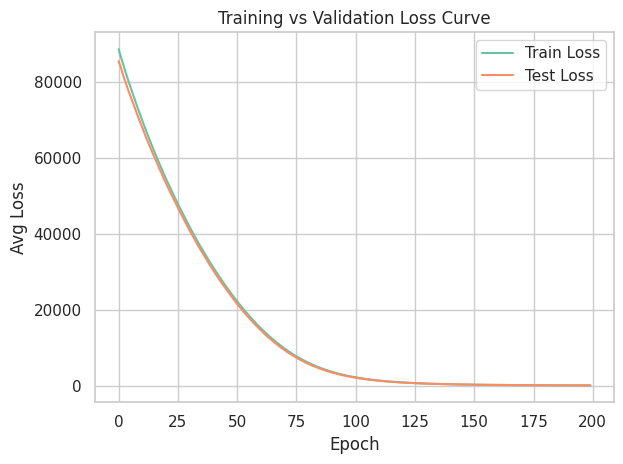

In [15]:
plt.plot(np.arange(200), train_losses , label = "Train Loss")
plt.plot(np.arange(200), test_losses , label = "Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation Scripts

In [16]:
model = ImplicitMF(num_users, num_items, d_model)
ckpt = torch.load("models/implicitALSDL.pt", weights_only=False)
model.load_state_dict(ckpt['state_dict'])
model.to(device)

ImplicitMF(
  (user_embeddings): Embedding(6040, 128)
  (item_embeddings): Embedding(3706, 128)
)

In [17]:
train_ndcgs = {}
test_ndcgs = {}

k_range = [5,10,20]

for user_idx in tqdm(range(num_users)):
    train_df_user = train_df[train_df['user_idx'] == user_idx]
    gt_train_items = train_df_user['movie_idx'].to_list()
    gt_train_ratings = train_df_user['rating'].to_list()

    test_df_user = test_df[test_df['user_idx'] == user_idx]
    gt_test_items = test_df_user['movie_idx'].to_list()
    gt_test_ratings = test_df_user['rating'].to_list()
    
    user_vec = model.user_embeddings(torch.tensor([user_idx]).to(device))
    train_item_vecs = model.item_embeddings(torch.tensor(gt_train_items).to(device))
    user_train_item_affinities = (user_vec * train_item_vecs).sum(dim=1).detach().cpu().numpy().tolist()
    
    test_item_vecs = model.item_embeddings(torch.tensor(gt_test_items).to(device))
    user_test_item_affinities = (user_vec * test_item_vecs).sum(dim=1).detach().cpu().numpy().tolist()
    
    for k in k_range:
        if k not in train_ndcgs.keys():
            train_ndcgs[k] = []
        if k not in test_ndcgs.keys():
            test_ndcgs[k] = []
        train_ndcgs[k].append(ndcg_score([gt_train_ratings], [user_train_item_affinities], k=k))
        test_ndcgs[k].append(ndcg_score([gt_test_ratings], [user_test_item_affinities], k=k))
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:23<00:00, 252.57it/s]


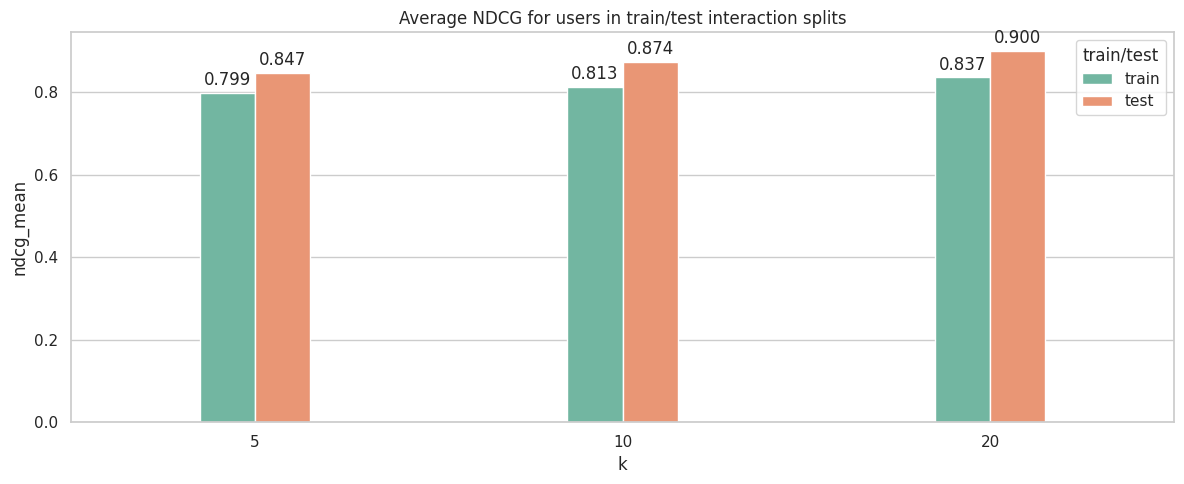

In [18]:
train_ndcgs_mean = [np.array(train_ndcgs[k]).mean() for k in k_range]
test_ndcgs_mean = [np.array(test_ndcgs[k]).mean() for k in k_range]

ndcg_metric_df = pd.concat([pd.DataFrame({'k' : k_range, 'ndcg_mean' : train_ndcgs_mean, 'train/test' : ['train' for k in k_range]}),
           pd.DataFrame({'k' : k_range, 'ndcg_mean' : test_ndcgs_mean, 'train/test' : ['test' for k in k_range]})])

plt.figure(figsize=(12,5))

ax = sns.barplot(data=ndcg_metric_df, x='k', y='ndcg_mean', hue='train/test', width=0.3)

# Add value labels over each bar
for p, value in zip(ax.patches, ndcg_metric_df['ndcg_mean']):
    ax.annotate(f'{value:.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
plt.title("Average NDCG for users in train/test interaction splits")
plt.tight_layout()
plt.show()

### Approach 2: Implicit ALS with user and item bias

#### Model

In [19]:
class ImplicitMF_Bias(nn.Module):
    def __init__(self, num_users, num_items, d_model):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.d_model = d_model
        self.user_embeddings = nn.Embedding(self.num_users, d_model)
        self.item_embeddings = nn.Embedding(self.num_items, d_model)
        self.user_bias = nn.Embedding(self.num_users, 1)
        self.item_bias = nn.Embedding(self.num_items, 1)

    def forward(self, user, item):
        u = self.user_embeddings(user)
        v = self.item_embeddings(item)
        b_u = self.user_bias(user).squeeze()
        b_i = self.user_bias(item).squeeze()
        
        return (u * v).sum(dim=1) + b_u + b_i

### Train Loop

In [20]:
def loop(model, optimiser, dataloader, reg_lambda, device, epoch, verbose=True, train=True):
    model = model.to(device)    
    total_loss = []
    iterator = tqdm(dataloader) if verbose else dataloader
    for batch in iterator:
        iterator.set_description(f"Epoch {epoch}  ||  Total Loss : {np.array(total_loss).mean():.4f}")
        user = batch['user'].to(device)
        item = batch['item'].to(device)
        confidence = batch['confidence'].to(device)
        preference = batch['preference'].to(device)

        if train:
            pred = model(user, item)
            loss = (confidence * ((preference - pred) ** 2)).mean()
            # reg = reg_lambda * (model.user_embeddings(user).norm(2).pow(2) + model.item_embeddings(item).norm(2).pow(2))
            reg = reg_lambda * (model.user_embeddings(user).norm(2).pow(2) + model.user_bias(user).pow(2).sum() + model.item_embeddings(item).norm(2).pow(2) + model.item_bias(item).pow(2).sum())
            # print(loss.shape, reg.shape)
            loss += reg
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            total_loss.append(loss.item())
        else:
            with torch.no_grad():
                pred = model(user, item)
                loss = (confidence * ((preference - pred) ** 2)).mean()
                # print(loss.shape)
                reg = reg_lambda * (model.user_embeddings(user).norm(2).pow(2) + model.user_bias(user).pow(2).sum() + model.item_embeddings(item).norm(2).pow(2) + model.item_bias(item).pow(2).sum())
                # print(reg.shape)
                loss += reg
                total_loss.append(loss.item())
    return np.array(total_loss).mean()


def run(model, optimiser, train_dataloader, test_dataloader, reg_lambda, device, ckpt_path, epochs=20, verbose=True, patience=5):
    best_test_loss = 1e6
    train_losses = []
    test_losses = []

    counter = patience
    for epoch in range(epochs):
        if counter == 0:
            print("ENDING TRAINING LOOP DUE TO PATIENCE!!")
            break
        train_loss = loop(model, optimiser, train_dataloader, reg_lambda, device, epoch, verbose=True, train=True)
        test_loss = loop(model, optimiser, test_dataloader, reg_lambda, device, epoch, verbose=True, train=False)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if test_loss < best_test_loss:
            counter = patience
            torch.save({
                        'epoch' : epoch,
                        'val_loss' : test_loss,
                        'state_dict' : model.state_dict()
                    }, ckpt_path)
            best_test_loss = test_loss
            print("Saving CKPT")
        else:
            counter -= 1
        print("\n")
    return train_losses, test_losses

In [21]:
model = ImplicitMF_Bias(num_users, num_items, d_model)
optimiser = optim.Adam(model.parameters(), lr=lr)
ckpt_path = "models/implicitALS_Bias_DL.pt"
train_losses, test_losses = run(model, optimiser, train_loader, test_loader, reg_lambda=0.1, device=device, ckpt_path=ckpt_path, epochs=200, verbose=True)

  0%|                                                                                                                                                                | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_3379851/1641483355.py:6: RuntimeWarning: Mean of empty slice.
  iterator.set_description(f"Epoch {epoch}  ||  Total Loss : {np.array(total_loss).mean():.4f}")
/opt2/shreyas/miniconda3/envs/cf/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 0  ||  Total Loss : 226145.2759: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.52it/s]
Epoch 0  ||  Total Loss : 222442.0331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.15it/s]


Saving CKPT




Epoch 1  ||  Total Loss : 218784.5933: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.11it/s]
Epoch 1  ||  Total Loss : 215265.6240: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.32it/s]


Saving CKPT




Epoch 2  ||  Total Loss : 211657.6984: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.27it/s]
Epoch 2  ||  Total Loss : 208316.6352: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.64it/s]


Saving CKPT




Epoch 3  ||  Total Loss : 204742.2295: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.99it/s]
Epoch 3  ||  Total Loss : 201554.4439: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.26it/s]


Saving CKPT




Epoch 4  ||  Total Loss : 198051.2418: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.88it/s]
Epoch 4  ||  Total Loss : 195000.7988: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.98it/s]


Saving CKPT




Epoch 5  ||  Total Loss : 191558.7229: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.75it/s]
Epoch 5  ||  Total Loss : 188651.0835: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.21it/s]


Saving CKPT




Epoch 6  ||  Total Loss : 185259.9725: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.81it/s]
Epoch 6  ||  Total Loss : 182468.8162: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.43it/s]


Saving CKPT




Epoch 7  ||  Total Loss : 179149.1997: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.26it/s]
Epoch 7  ||  Total Loss : 176456.6380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.63it/s]


Saving CKPT




Epoch 8  ||  Total Loss : 173216.4844: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.56it/s]
Epoch 8  ||  Total Loss : 170636.5652: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.24it/s]


Saving CKPT




Epoch 9  ||  Total Loss : 167461.8131: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.55it/s]
Epoch 9  ||  Total Loss : 164974.6714: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.42it/s]


Saving CKPT




Epoch 10  ||  Total Loss : 161869.5203: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 92.97it/s]
Epoch 10  ||  Total Loss : 159479.6447: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.19it/s]


Saving CKPT




Epoch 11  ||  Total Loss : 156447.5746: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.52it/s]
Epoch 11  ||  Total Loss : 154133.7851: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.25it/s]


Saving CKPT




Epoch 12  ||  Total Loss : 151188.0641: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 92.31it/s]
Epoch 12  ||  Total Loss : 148946.1350: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.28it/s]


Saving CKPT




Epoch 13  ||  Total Loss : 146070.9605: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.84it/s]
Epoch 13  ||  Total Loss : 143908.0306: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.06it/s]


Saving CKPT




Epoch 14  ||  Total Loss : 141106.0136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.76it/s]
Epoch 14  ||  Total Loss : 139014.3998: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.95it/s]


Saving CKPT




Epoch 15  ||  Total Loss : 136289.4522: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.13it/s]
Epoch 15  ||  Total Loss : 134263.7271: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.27it/s]


Saving CKPT




Epoch 16  ||  Total Loss : 131613.7229: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.89it/s]
Epoch 16  ||  Total Loss : 129637.0606: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.83it/s]


Saving CKPT




Epoch 17  ||  Total Loss : 127074.4043: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.09it/s]
Epoch 17  ||  Total Loss : 125145.6325: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.77it/s]


Saving CKPT




Epoch 18  ||  Total Loss : 122663.0656: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.87it/s]
Epoch 18  ||  Total Loss : 120791.9253: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Saving CKPT




Epoch 19  ||  Total Loss : 118379.5607: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.59it/s]
Epoch 19  ||  Total Loss : 116556.9610: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.50it/s]


Saving CKPT




Epoch 20  ||  Total Loss : 114222.2324: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.86it/s]
Epoch 20  ||  Total Loss : 112447.5544: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.65it/s]


Saving CKPT




Epoch 21  ||  Total Loss : 110180.9918: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.22it/s]
Epoch 21  ||  Total Loss : 108458.1289: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.41it/s]


Saving CKPT




Epoch 22  ||  Total Loss : 106268.7047: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.68it/s]
Epoch 22  ||  Total Loss : 104587.1126: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.04it/s]


Saving CKPT




Epoch 23  ||  Total Loss : 102467.6408: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.15it/s]
Epoch 23  ||  Total Loss : 100821.5780: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.58it/s]


Saving CKPT




Epoch 24  ||  Total Loss : 98780.3971: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.34it/s]
Epoch 24  ||  Total Loss : 97173.6292: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.83it/s]


Saving CKPT




Epoch 25  ||  Total Loss : 95201.7198: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.08it/s]
Epoch 25  ||  Total Loss : 93636.4309: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.87it/s]


Saving CKPT




Epoch 26  ||  Total Loss : 91732.0623: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.95it/s]
Epoch 26  ||  Total Loss : 90201.6199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.97it/s]


Saving CKPT




Epoch 27  ||  Total Loss : 88362.6177: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.54it/s]
Epoch 27  ||  Total Loss : 86875.3586: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.99it/s]


Saving CKPT




Epoch 28  ||  Total Loss : 85096.2260: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 91.51it/s]
Epoch 28  ||  Total Loss : 83636.4583: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.26it/s]


Saving CKPT




Epoch 29  ||  Total Loss : 81933.6685: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.22it/s]
Epoch 29  ||  Total Loss : 80506.6603: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.11it/s]


Saving CKPT




Epoch 30  ||  Total Loss : 78865.7249: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.78it/s]
Epoch 30  ||  Total Loss : 77475.8565: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.48it/s]


Saving CKPT




Epoch 31  ||  Total Loss : 75891.5564: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.93it/s]
Epoch 31  ||  Total Loss : 74533.0158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.84it/s]


Saving CKPT




Epoch 32  ||  Total Loss : 73013.4717: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.48it/s]
Epoch 32  ||  Total Loss : 71688.6715: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.85it/s]


Saving CKPT




Epoch 33  ||  Total Loss : 70220.5331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.53it/s]
Epoch 33  ||  Total Loss : 68937.3242: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 34  ||  Total Loss : 67526.7941: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.80it/s]
Epoch 34  ||  Total Loss : 66266.6139: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.32it/s]


Saving CKPT




Epoch 35  ||  Total Loss : 64906.8240: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.37it/s]
Epoch 35  ||  Total Loss : 63686.7543: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.91it/s]


Saving CKPT




Epoch 36  ||  Total Loss : 62381.0046: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 67.93it/s]
Epoch 36  ||  Total Loss : 61191.4074: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 28.47it/s]


Saving CKPT




Epoch 37  ||  Total Loss : 59936.7160: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 60.98it/s]
Epoch 37  ||  Total Loss : 58773.3150: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.50it/s]


Saving CKPT




Epoch 38  ||  Total Loss : 57569.5294: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.42it/s]
Epoch 38  ||  Total Loss : 56435.7863: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.29it/s]


Saving CKPT




Epoch 39  ||  Total Loss : 55285.8029: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.92it/s]
Epoch 39  ||  Total Loss : 54184.7803: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.32it/s]


Saving CKPT




Epoch 40  ||  Total Loss : 53077.5216: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.42it/s]
Epoch 40  ||  Total Loss : 52000.3526: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.74it/s]


Saving CKPT




Epoch 41  ||  Total Loss : 50941.4698: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.98it/s]
Epoch 41  ||  Total Loss : 49898.5602: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.69it/s]


Saving CKPT




Epoch 42  ||  Total Loss : 48881.0437: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.10it/s]
Epoch 42  ||  Total Loss : 47865.9150: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.28it/s]


Saving CKPT




Epoch 43  ||  Total Loss : 46890.4001: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.45it/s]
Epoch 43  ||  Total Loss : 45903.3484: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.16it/s]


Saving CKPT




Epoch 44  ||  Total Loss : 44971.1354: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.84it/s]
Epoch 44  ||  Total Loss : 44010.4578: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.71it/s]


Saving CKPT




Epoch 45  ||  Total Loss : 43118.0988: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.37it/s]
Epoch 45  ||  Total Loss : 42185.8423: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.13it/s]


Saving CKPT




Epoch 46  ||  Total Loss : 41331.9592: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.82it/s]
Epoch 46  ||  Total Loss : 40433.8643: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.74it/s]


Saving CKPT




Epoch 47  ||  Total Loss : 39610.7799: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.01it/s]
Epoch 47  ||  Total Loss : 38738.0060: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.32it/s]


Saving CKPT




Epoch 48  ||  Total Loss : 37953.5644: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.00it/s]
Epoch 48  ||  Total Loss : 37101.4793: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.80it/s]


Saving CKPT




Epoch 49  ||  Total Loss : 36354.2695: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 93.76it/s]
Epoch 49  ||  Total Loss : 35527.6035: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.85it/s]


Saving CKPT




Epoch 50  ||  Total Loss : 34814.9089: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.52it/s]
Epoch 50  ||  Total Loss : 34014.1529: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.01it/s]


Saving CKPT




Epoch 51  ||  Total Loss : 33333.1887: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.91it/s]
Epoch 51  ||  Total Loss : 32562.0779: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.09it/s]


Saving CKPT




Epoch 52  ||  Total Loss : 31903.5862: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.92it/s]
Epoch 52  ||  Total Loss : 31158.4215: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.48it/s]


Saving CKPT




Epoch 53  ||  Total Loss : 30534.3294: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.06it/s]
Epoch 53  ||  Total Loss : 29814.5785: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.19it/s]


Saving CKPT




Epoch 54  ||  Total Loss : 29213.2416: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.65it/s]
Epoch 54  ||  Total Loss : 28518.0568: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.81it/s]


Saving CKPT




Epoch 55  ||  Total Loss : 27946.1583: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.55it/s]
Epoch 55  ||  Total Loss : 27269.6231: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.96it/s]


Saving CKPT




Epoch 56  ||  Total Loss : 26727.9570: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.72it/s]
Epoch 56  ||  Total Loss : 26078.0563: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.21it/s]


Saving CKPT




Epoch 57  ||  Total Loss : 25556.7050: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.56it/s]
Epoch 57  ||  Total Loss : 24928.4155: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.02it/s]


Saving CKPT




Epoch 58  ||  Total Loss : 24432.3004: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.92it/s]
Epoch 58  ||  Total Loss : 23828.3758: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.91it/s]


Saving CKPT




Epoch 59  ||  Total Loss : 23353.1198: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.00it/s]
Epoch 59  ||  Total Loss : 22770.0423: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.13it/s]


Saving CKPT




Epoch 60  ||  Total Loss : 22314.1132: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.82it/s]
Epoch 60  ||  Total Loss : 21755.0181: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.07it/s]


Saving CKPT




Epoch 61  ||  Total Loss : 21321.6700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 92.27it/s]
Epoch 61  ||  Total Loss : 20779.1134: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.34it/s]


Saving CKPT




Epoch 62  ||  Total Loss : 20368.6619: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.92it/s]
Epoch 62  ||  Total Loss : 19846.9504: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.07it/s]


Saving CKPT




Epoch 63  ||  Total Loss : 19453.5373: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.95it/s]
Epoch 63  ||  Total Loss : 18954.0129: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.18it/s]


Saving CKPT




Epoch 64  ||  Total Loss : 18576.5763: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.24it/s]
Epoch 64  ||  Total Loss : 18097.4132: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.24it/s]


Saving CKPT




Epoch 65  ||  Total Loss : 17739.4970: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.87it/s]
Epoch 65  ||  Total Loss : 17275.4074: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.70it/s]


Saving CKPT




Epoch 66  ||  Total Loss : 16935.0737: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.13it/s]
Epoch 66  ||  Total Loss : 16486.9319: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.19it/s]


Saving CKPT




Epoch 67  ||  Total Loss : 16163.6219: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.37it/s]
Epoch 67  ||  Total Loss : 15735.5355: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.64it/s]


Saving CKPT




Epoch 68  ||  Total Loss : 15425.4676: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.77it/s]
Epoch 68  ||  Total Loss : 15018.6659: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.19it/s]


Saving CKPT




Epoch 69  ||  Total Loss : 14721.0764: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.96it/s]
Epoch 69  ||  Total Loss : 14325.7239: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.53it/s]


Saving CKPT




Epoch 70  ||  Total Loss : 14046.9698: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.78it/s]
Epoch 70  ||  Total Loss : 13667.3684: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.76it/s]


Saving CKPT




Epoch 71  ||  Total Loss : 13397.6343: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.47it/s]
Epoch 71  ||  Total Loss : 13036.6918: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.42it/s]


Saving CKPT




Epoch 72  ||  Total Loss : 12781.0214: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.56it/s]
Epoch 72  ||  Total Loss : 12431.7786: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.48it/s]


Saving CKPT




Epoch 73  ||  Total Loss : 12189.7256: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.73it/s]
Epoch 73  ||  Total Loss : 11857.4473: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.18it/s]


Saving CKPT




Epoch 74  ||  Total Loss : 11625.8153: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.37it/s]
Epoch 74  ||  Total Loss : 11305.7733: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.96it/s]


Saving CKPT




Epoch 75  ||  Total Loss : 11084.3643: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.41it/s]
Epoch 75  ||  Total Loss : 10780.3505: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.74it/s]


Saving CKPT




Epoch 76  ||  Total Loss : 10568.6984: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.17it/s]
Epoch 76  ||  Total Loss : 10276.0618: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.69it/s]


Saving CKPT




Epoch 77  ||  Total Loss : 10077.7794: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.49it/s]
Epoch 77  ||  Total Loss : 9795.4342: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.41it/s]


Saving CKPT




Epoch 78  ||  Total Loss : 9605.1694: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.57it/s]
Epoch 78  ||  Total Loss : 9336.7840: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.90it/s]


Saving CKPT




Epoch 79  ||  Total Loss : 9156.5879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.87it/s]
Epoch 79  ||  Total Loss : 8897.2871: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 80  ||  Total Loss : 8727.7970: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.05it/s]
Epoch 80  ||  Total Loss : 8481.7259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.26it/s]


Saving CKPT




Epoch 81  ||  Total Loss : 8318.5149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.90it/s]
Epoch 81  ||  Total Loss : 8083.1692: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.45it/s]


Saving CKPT




Epoch 82  ||  Total Loss : 7928.7700: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.34it/s]
Epoch 82  ||  Total Loss : 7703.5666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.31it/s]


Saving CKPT




Epoch 83  ||  Total Loss : 7555.3966: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.61it/s]
Epoch 83  ||  Total Loss : 7341.9300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.20it/s]


Saving CKPT




Epoch 84  ||  Total Loss : 7198.7786: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.93it/s]
Epoch 84  ||  Total Loss : 6997.5531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.35it/s]


Saving CKPT




Epoch 85  ||  Total Loss : 6861.8328: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.62it/s]
Epoch 85  ||  Total Loss : 6667.8433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.54it/s]


Saving CKPT




Epoch 86  ||  Total Loss : 6537.9759: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.74it/s]
Epoch 86  ||  Total Loss : 6352.4952: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.11it/s]


Saving CKPT




Epoch 87  ||  Total Loss : 6230.2602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.36it/s]
Epoch 87  ||  Total Loss : 6051.0231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.95it/s]


Saving CKPT




Epoch 88  ||  Total Loss : 5935.8941: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.72it/s]
Epoch 88  ||  Total Loss : 5768.2961: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.62it/s]


Saving CKPT




Epoch 89  ||  Total Loss : 5657.8460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.57it/s]
Epoch 89  ||  Total Loss : 5496.1501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.95it/s]


Saving CKPT




Epoch 90  ||  Total Loss : 5389.0698: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.05it/s]
Epoch 90  ||  Total Loss : 5238.6590: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.44it/s]


Saving CKPT




Epoch 91  ||  Total Loss : 5137.2113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.50it/s]
Epoch 91  ||  Total Loss : 4990.7161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.35it/s]


Saving CKPT




Epoch 92  ||  Total Loss : 4894.5157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.63it/s]
Epoch 92  ||  Total Loss : 4757.6228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.33it/s]


Saving CKPT




Epoch 93  ||  Total Loss : 4664.7748: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.82it/s]
Epoch 93  ||  Total Loss : 4532.8625: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.18it/s]


Saving CKPT




Epoch 94  ||  Total Loss : 4444.9374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.07it/s]
Epoch 94  ||  Total Loss : 4320.5878: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.35it/s]


Saving CKPT




Epoch 95  ||  Total Loss : 4236.9290: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.59it/s]
Epoch 95  ||  Total Loss : 4118.2491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.04it/s]


Saving CKPT




Epoch 96  ||  Total Loss : 4037.5156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.97it/s]
Epoch 96  ||  Total Loss : 3924.8049: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.80it/s]


Saving CKPT




Epoch 97  ||  Total Loss : 3848.8652: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.65it/s]
Epoch 97  ||  Total Loss : 3740.5570: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.29it/s]


Saving CKPT




Epoch 98  ||  Total Loss : 3668.9103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.72it/s]
Epoch 98  ||  Total Loss : 3566.7505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 42.61it/s]


Saving CKPT




Epoch 99  ||  Total Loss : 3497.4784: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.35it/s]
Epoch 99  ||  Total Loss : 3401.0620: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.45it/s]


Saving CKPT




Epoch 100  ||  Total Loss : 3334.1993: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.68it/s]
Epoch 100  ||  Total Loss : 3242.0714: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.66it/s]


Saving CKPT




Epoch 101  ||  Total Loss : 3178.6773: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.74it/s]
Epoch 101  ||  Total Loss : 3091.9246: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.15it/s]


Saving CKPT




Epoch 102  ||  Total Loss : 3031.7732: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.57it/s]
Epoch 102  ||  Total Loss : 2948.9234: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.36it/s]


Saving CKPT




Epoch 103  ||  Total Loss : 2891.0627: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.48it/s]
Epoch 103  ||  Total Loss : 2812.6275: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.52it/s]


Saving CKPT




Epoch 104  ||  Total Loss : 2757.8188: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.16it/s]
Epoch 104  ||  Total Loss : 2683.0930: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.53it/s]


Saving CKPT




Epoch 105  ||  Total Loss : 2630.1227: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.03it/s]
Epoch 105  ||  Total Loss : 2561.0269: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.30it/s]


Saving CKPT




Epoch 106  ||  Total Loss : 2509.1829: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.55it/s]
Epoch 106  ||  Total Loss : 2443.3736: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.19it/s]


Saving CKPT




Epoch 107  ||  Total Loss : 2394.3863: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.54it/s]
Epoch 107  ||  Total Loss : 2332.3644: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.82it/s]


Saving CKPT




Epoch 108  ||  Total Loss : 2285.5158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.72it/s]
Epoch 108  ||  Total Loss : 2225.6842: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.07it/s]


Saving CKPT




Epoch 109  ||  Total Loss : 2180.8182: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.36it/s]
Epoch 109  ||  Total Loss : 2126.7272: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.98it/s]


Saving CKPT




Epoch 110  ||  Total Loss : 2081.9643: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.89it/s]
Epoch 110  ||  Total Loss : 2029.2724: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.94it/s]


Saving CKPT




Epoch 111  ||  Total Loss : 1987.4959: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.74it/s]
Epoch 111  ||  Total Loss : 1938.5011: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.50it/s]


Saving CKPT




Epoch 112  ||  Total Loss : 1897.7998: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.58it/s]
Epoch 112  ||  Total Loss : 1852.3089: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.77it/s]


Saving CKPT




Epoch 113  ||  Total Loss : 1813.1994: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.71it/s]
Epoch 113  ||  Total Loss : 1769.9487: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.15it/s]


Saving CKPT




Epoch 114  ||  Total Loss : 1731.8371: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.16it/s]
Epoch 114  ||  Total Loss : 1692.2513: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.03it/s]


Saving CKPT




Epoch 115  ||  Total Loss : 1654.8980: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.55it/s]
Epoch 115  ||  Total Loss : 1617.5498: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.25it/s]


Saving CKPT




Epoch 116  ||  Total Loss : 1580.9849: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.64it/s]
Epoch 116  ||  Total Loss : 1545.6151: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.38it/s]


Saving CKPT




Epoch 117  ||  Total Loss : 1511.5850: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.02it/s]
Epoch 117  ||  Total Loss : 1480.5135: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.53it/s]


Saving CKPT




Epoch 118  ||  Total Loss : 1445.7104: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.62it/s]
Epoch 118  ||  Total Loss : 1415.6885: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.05it/s]


Saving CKPT




Epoch 119  ||  Total Loss : 1382.6012: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.90it/s]
Epoch 119  ||  Total Loss : 1355.0617: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.30it/s]


Saving CKPT




Epoch 120  ||  Total Loss : 1323.1507: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.40it/s]
Epoch 120  ||  Total Loss : 1296.9810: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.27it/s]


Saving CKPT




Epoch 121  ||  Total Loss : 1265.5381: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.73it/s]
Epoch 121  ||  Total Loss : 1241.6122: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.74it/s]


Saving CKPT




Epoch 122  ||  Total Loss : 1211.0684: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.85it/s]
Epoch 122  ||  Total Loss : 1188.4500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.31it/s]


Saving CKPT




Epoch 123  ||  Total Loss : 1159.3205: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.69it/s]
Epoch 123  ||  Total Loss : 1139.6352: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.57it/s]


Saving CKPT




Epoch 124  ||  Total Loss : 1110.4494: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.12it/s]
Epoch 124  ||  Total Loss : 1092.3614: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.33it/s]


Saving CKPT




Epoch 125  ||  Total Loss : 1063.2331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.96it/s]
Epoch 125  ||  Total Loss : 1046.9056: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.07it/s]


Saving CKPT




Epoch 126  ||  Total Loss : 1019.5976: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.65it/s]
Epoch 126  ||  Total Loss : 1003.7052: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.80it/s]


Saving CKPT




Epoch 127  ||  Total Loss : 976.5917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.07it/s]
Epoch 127  ||  Total Loss : 963.0480: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.64it/s]


Saving CKPT




Epoch 128  ||  Total Loss : 936.2844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.34it/s]
Epoch 128  ||  Total Loss : 923.8789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.82it/s]


Saving CKPT




Epoch 129  ||  Total Loss : 898.1539: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.97it/s]
Epoch 129  ||  Total Loss : 886.4577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.86it/s]


Saving CKPT




Epoch 130  ||  Total Loss : 861.4141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.82it/s]
Epoch 130  ||  Total Loss : 852.3929: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Saving CKPT




Epoch 131  ||  Total Loss : 826.3960: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.91it/s]
Epoch 131  ||  Total Loss : 818.5531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.51it/s]


Saving CKPT




Epoch 132  ||  Total Loss : 793.3646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.61it/s]
Epoch 132  ||  Total Loss : 786.4078: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.20it/s]


Saving CKPT




Epoch 133  ||  Total Loss : 762.0059: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.21it/s]
Epoch 133  ||  Total Loss : 756.3091: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.13it/s]


Saving CKPT




Epoch 134  ||  Total Loss : 732.2061: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.10it/s]
Epoch 134  ||  Total Loss : 725.9144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.51it/s]


Saving CKPT




Epoch 135  ||  Total Loss : 703.1913: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.32it/s]
Epoch 135  ||  Total Loss : 700.0910: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.03it/s]


Saving CKPT




Epoch 136  ||  Total Loss : 675.8547: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.07it/s]
Epoch 136  ||  Total Loss : 673.3056: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.23it/s]


Saving CKPT




Epoch 137  ||  Total Loss : 650.2084: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 92.46it/s]
Epoch 137  ||  Total Loss : 648.4608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.66it/s]


Saving CKPT




Epoch 138  ||  Total Loss : 625.1563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.51it/s]
Epoch 138  ||  Total Loss : 625.0793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.22it/s]


Saving CKPT




Epoch 139  ||  Total Loss : 601.7419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.73it/s]
Epoch 139  ||  Total Loss : 601.8507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.20it/s]


Saving CKPT




Epoch 140  ||  Total Loss : 579.0349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.94it/s]
Epoch 140  ||  Total Loss : 580.1866: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.02it/s]


Saving CKPT




Epoch 141  ||  Total Loss : 557.8690: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 93.80it/s]
Epoch 141  ||  Total Loss : 560.0672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.32it/s]


Saving CKPT




Epoch 142  ||  Total Loss : 537.2009: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.74it/s]
Epoch 142  ||  Total Loss : 540.3462: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.64it/s]


Saving CKPT




Epoch 143  ||  Total Loss : 517.4377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.44it/s]
Epoch 143  ||  Total Loss : 521.4575: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.17it/s]


Saving CKPT




Epoch 144  ||  Total Loss : 499.3654: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.32it/s]
Epoch 144  ||  Total Loss : 503.8183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.95it/s]


Saving CKPT




Epoch 145  ||  Total Loss : 481.6582: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.96it/s]
Epoch 145  ||  Total Loss : 486.4446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.63it/s]


Saving CKPT




Epoch 146  ||  Total Loss : 464.6635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.21it/s]
Epoch 146  ||  Total Loss : 470.4465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.49it/s]


Saving CKPT




Epoch 147  ||  Total Loss : 448.4194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.91it/s]
Epoch 147  ||  Total Loss : 454.6737: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.79it/s]


Saving CKPT




Epoch 148  ||  Total Loss : 433.0135: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.10it/s]
Epoch 148  ||  Total Loss : 440.1969: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.00it/s]


Saving CKPT




Epoch 149  ||  Total Loss : 418.4180: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.59it/s]
Epoch 149  ||  Total Loss : 425.9014: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.48it/s]


Saving CKPT




Epoch 150  ||  Total Loss : 404.3688: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.71it/s]
Epoch 150  ||  Total Loss : 412.2948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.55it/s]


Saving CKPT




Epoch 151  ||  Total Loss : 390.9221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.06it/s]
Epoch 151  ||  Total Loss : 399.0125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.20it/s]


Saving CKPT




Epoch 152  ||  Total Loss : 378.1115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.39it/s]
Epoch 152  ||  Total Loss : 386.9636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.02it/s]


Saving CKPT




Epoch 153  ||  Total Loss : 365.7423: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.75it/s]
Epoch 153  ||  Total Loss : 375.3144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.49it/s]


Saving CKPT




Epoch 154  ||  Total Loss : 353.9176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.82it/s]
Epoch 154  ||  Total Loss : 362.9624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.81it/s]


Saving CKPT




Epoch 155  ||  Total Loss : 343.0452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.98it/s]
Epoch 155  ||  Total Loss : 352.1224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.08it/s]


Saving CKPT




Epoch 156  ||  Total Loss : 332.1128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.06it/s]
Epoch 156  ||  Total Loss : 343.1891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.39it/s]


Saving CKPT




Epoch 157  ||  Total Loss : 321.8941: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.56it/s]
Epoch 157  ||  Total Loss : 332.9181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.04it/s]


Saving CKPT




Epoch 158  ||  Total Loss : 311.9849: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.20it/s]
Epoch 158  ||  Total Loss : 322.7060: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.49it/s]


Saving CKPT




Epoch 159  ||  Total Loss : 302.6139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.99it/s]
Epoch 159  ||  Total Loss : 314.6946: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.72it/s]


Saving CKPT




Epoch 160  ||  Total Loss : 293.9585: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 93.27it/s]
Epoch 160  ||  Total Loss : 305.4089: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.47it/s]


Saving CKPT




Epoch 161  ||  Total Loss : 285.0598: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 84.50it/s]
Epoch 161  ||  Total Loss : 297.8463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.13it/s]


Saving CKPT




Epoch 162  ||  Total Loss : 276.8083: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 60.25it/s]
Epoch 162  ||  Total Loss : 290.0259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.22it/s]


Saving CKPT




Epoch 163  ||  Total Loss : 268.8903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.70it/s]
Epoch 163  ||  Total Loss : 282.6057: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.97it/s]


Saving CKPT




Epoch 164  ||  Total Loss : 261.7060: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.89it/s]
Epoch 164  ||  Total Loss : 275.0540: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.98it/s]


Saving CKPT




Epoch 165  ||  Total Loss : 254.3221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.50it/s]
Epoch 165  ||  Total Loss : 267.9879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.77it/s]


Saving CKPT




Epoch 166  ||  Total Loss : 247.4693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.17it/s]
Epoch 166  ||  Total Loss : 261.4947: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.47it/s]


Saving CKPT




Epoch 167  ||  Total Loss : 240.6623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.65it/s]
Epoch 167  ||  Total Loss : 254.8576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.21it/s]


Saving CKPT




Epoch 168  ||  Total Loss : 234.6094: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 89.72it/s]
Epoch 168  ||  Total Loss : 248.7489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.82it/s]


Saving CKPT




Epoch 169  ||  Total Loss : 228.3663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 90.23it/s]
Epoch 169  ||  Total Loss : 242.8477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.51it/s]


Saving CKPT




Epoch 170  ||  Total Loss : 222.2284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.25it/s]
Epoch 170  ||  Total Loss : 237.4402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.29it/s]


Saving CKPT




Epoch 171  ||  Total Loss : 216.6568: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.07it/s]
Epoch 171  ||  Total Loss : 231.8176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.30it/s]


Saving CKPT




Epoch 172  ||  Total Loss : 211.4579: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.30it/s]
Epoch 172  ||  Total Loss : 226.5044: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.15it/s]


Saving CKPT




Epoch 173  ||  Total Loss : 206.3841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 94.45it/s]
Epoch 173  ||  Total Loss : 221.8127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.39it/s]


Saving CKPT




Epoch 174  ||  Total Loss : 201.3742: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.43it/s]
Epoch 174  ||  Total Loss : 216.5979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.92it/s]


Saving CKPT




Epoch 175  ||  Total Loss : 196.5091: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.08it/s]
Epoch 175  ||  Total Loss : 212.4215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.83it/s]


Saving CKPT




Epoch 176  ||  Total Loss : 191.8561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.51it/s]
Epoch 176  ||  Total Loss : 207.7756: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.52it/s]


Saving CKPT




Epoch 177  ||  Total Loss : 187.1072: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.85it/s]
Epoch 177  ||  Total Loss : 203.5753: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.00it/s]


Saving CKPT




Epoch 178  ||  Total Loss : 183.1794: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.85it/s]
Epoch 178  ||  Total Loss : 199.6138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.03it/s]


Saving CKPT




Epoch 179  ||  Total Loss : 179.0340: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.48it/s]
Epoch 179  ||  Total Loss : 195.4566: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.25it/s]


Saving CKPT




Epoch 180  ||  Total Loss : 175.1789: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.45it/s]
Epoch 180  ||  Total Loss : 191.7572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.56it/s]


Saving CKPT




Epoch 181  ||  Total Loss : 171.5392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.13it/s]
Epoch 181  ||  Total Loss : 188.0215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.37it/s]


Saving CKPT




Epoch 182  ||  Total Loss : 167.6874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.08it/s]
Epoch 182  ||  Total Loss : 184.6313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.09it/s]


Saving CKPT




Epoch 183  ||  Total Loss : 164.2208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.84it/s]
Epoch 183  ||  Total Loss : 180.7259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.65it/s]


Saving CKPT




Epoch 184  ||  Total Loss : 160.8196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.27it/s]
Epoch 184  ||  Total Loss : 177.7648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.74it/s]


Saving CKPT




Epoch 185  ||  Total Loss : 157.6045: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 93.23it/s]
Epoch 185  ||  Total Loss : 174.0767: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.26it/s]


Saving CKPT




Epoch 186  ||  Total Loss : 154.5824: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.56it/s]
Epoch 186  ||  Total Loss : 171.8550: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.49it/s]


Saving CKPT




Epoch 187  ||  Total Loss : 151.7004: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.78it/s]
Epoch 187  ||  Total Loss : 168.9715: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.12it/s]


Saving CKPT




Epoch 188  ||  Total Loss : 148.7257: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.67it/s]
Epoch 188  ||  Total Loss : 165.9784: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.15it/s]


Saving CKPT




Epoch 189  ||  Total Loss : 145.9367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.34it/s]
Epoch 189  ||  Total Loss : 163.3717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.81it/s]


Saving CKPT




Epoch 190  ||  Total Loss : 143.0820: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.22it/s]
Epoch 190  ||  Total Loss : 160.6648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.41it/s]


Saving CKPT




Epoch 191  ||  Total Loss : 140.8189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.02it/s]
Epoch 191  ||  Total Loss : 158.5236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.20it/s]


Saving CKPT




Epoch 192  ||  Total Loss : 138.2627: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.38it/s]
Epoch 192  ||  Total Loss : 155.7867: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.65it/s]


Saving CKPT




Epoch 193  ||  Total Loss : 135.8864: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.84it/s]
Epoch 193  ||  Total Loss : 153.7378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.54it/s]


Saving CKPT




Epoch 194  ||  Total Loss : 133.6315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 95.27it/s]
Epoch 194  ||  Total Loss : 151.5506: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.50it/s]


Saving CKPT




Epoch 195  ||  Total Loss : 131.4698: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 97.07it/s]
Epoch 195  ||  Total Loss : 149.2826: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.07it/s]


Saving CKPT




Epoch 196  ||  Total Loss : 129.2368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98.99it/s]
Epoch 196  ||  Total Loss : 147.1760: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.71it/s]


Saving CKPT




Epoch 197  ||  Total Loss : 127.2546: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 99.37it/s]
Epoch 197  ||  Total Loss : 144.9072: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.54it/s]


Saving CKPT




Epoch 198  ||  Total Loss : 125.1367: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 100.19it/s]
Epoch 198  ||  Total Loss : 143.0250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.08it/s]


Saving CKPT




Epoch 199  ||  Total Loss : 123.2509: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 96.71it/s]
Epoch 199  ||  Total Loss : 140.8765: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.35it/s]

Saving CKPT




#### Evaluation Scripts

In [22]:
model = ImplicitMF_Bias(num_users, num_items, d_model)
ckpt = torch.load("models/implicitALS_Bias_DL.pt", weights_only=False)
model.load_state_dict(ckpt['state_dict'])
model.to(device)

ImplicitMF_Bias(
  (user_embeddings): Embedding(6040, 128)
  (item_embeddings): Embedding(3706, 128)
  (user_bias): Embedding(6040, 1)
  (item_bias): Embedding(3706, 1)
)

In [23]:
train_ndcgs = {}
test_ndcgs = {}

k_range = [5,10,20]

for user_idx in tqdm(range(num_users)):
    train_df_user = train_df[train_df['user_idx'] == user_idx]
    gt_train_items = train_df_user['movie_idx'].to_list()
    gt_train_ratings = train_df_user['rating'].to_list()

    test_df_user = test_df[test_df['user_idx'] == user_idx]
    gt_test_items = test_df_user['movie_idx'].to_list()
    gt_test_ratings = test_df_user['rating'].to_list()
    
    user_vec = model.user_embeddings(torch.tensor([user_idx]).to(device))
    train_item_vecs = model.item_embeddings(torch.tensor(gt_train_items).to(device))
    user_train_item_affinities = (user_vec * train_item_vecs).sum(dim=1).detach().cpu().numpy().tolist()
    
    test_item_vecs = model.item_embeddings(torch.tensor(gt_test_items).to(device))
    user_test_item_affinities = (user_vec * test_item_vecs).sum(dim=1).detach().cpu().numpy().tolist()
    
    for k in k_range:
        if k not in train_ndcgs.keys():
            train_ndcgs[k] = []
        if k not in test_ndcgs.keys():
            test_ndcgs[k] = []
        train_ndcgs[k].append(ndcg_score([gt_train_ratings], [user_train_item_affinities], k=k))
        test_ndcgs[k].append(ndcg_score([gt_test_ratings], [user_test_item_affinities], k=k))
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:24<00:00, 251.46it/s]


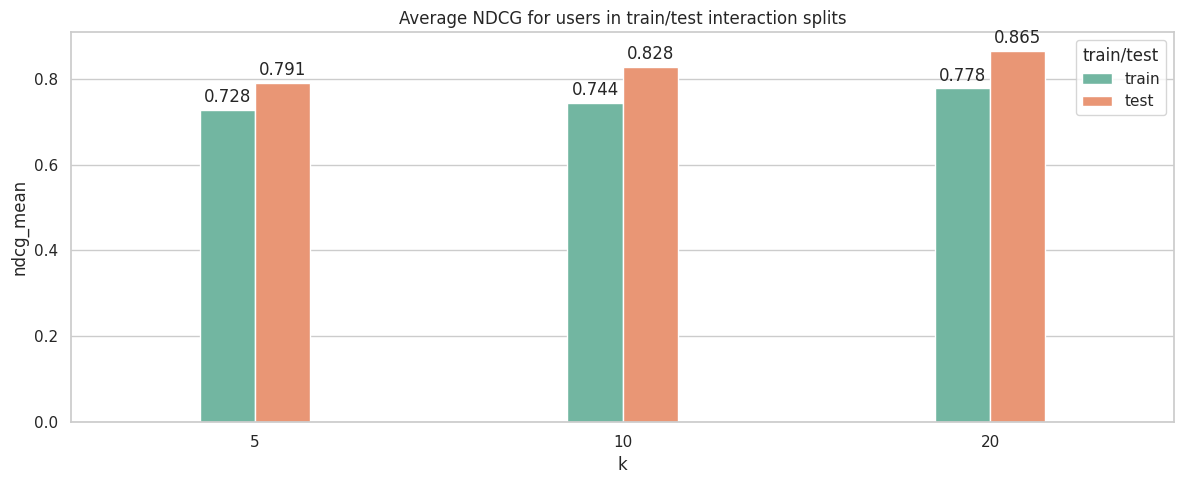

In [24]:
train_ndcgs_mean = [np.array(train_ndcgs[k]).mean() for k in k_range]
test_ndcgs_mean = [np.array(test_ndcgs[k]).mean() for k in k_range]

ndcg_metric_df = pd.concat([pd.DataFrame({'k' : k_range, 'ndcg_mean' : train_ndcgs_mean, 'train/test' : ['train' for k in k_range]}),
           pd.DataFrame({'k' : k_range, 'ndcg_mean' : test_ndcgs_mean, 'train/test' : ['test' for k in k_range]})])

plt.figure(figsize=(12,5))

ax = sns.barplot(data=ndcg_metric_df, x='k', y='ndcg_mean', hue='train/test', width=0.3)

# Add value labels over each bar
for p, value in zip(ax.patches, ndcg_metric_df['ndcg_mean']):
    ax.annotate(f'{value:.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
plt.title("Average NDCG for users in train/test interaction splits")
plt.tight_layout()
plt.show()